In [1]:
import torch
import os
import sys

from pathlib import Path
project_path = Path.cwd().parent.parent
sys.path.append(project_path.__str__())

from regressor_on_resnet.batch_factory import BatchFactory
from regressor_on_resnet.flux_dataset import FluxDataset
from regressor_on_resnet.metrics import MseLoss
from regressor_on_resnet.nn_logging import Logger
from regressor_on_resnet.metadata_loader import MetadataLoader
from regressor_on_resnet.resnet_regressor import ResnetRegressor
from regressor_on_resnet.sgdr_restarts_warmup import CosineAnnealingWarmupRestarts
from regressor_on_resnet.train_common import Trainer

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import trange, tqdm
import numpy as np

# Create some objects to deal with dataset

In [3]:
batch_size = 32
cuda_device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

output_size = (512, 512)
batch_fields = ['images',
                'masks',
                'fluxes',
                'elevations']

metadata_loader = MetadataLoader((
    project_path / 'cloud_applications_v2/expeditions_configs/AI-58-config.json',
    project_path / 'cloud_applications_v2/expeditions_configs/AMK-79-config.json',
    project_path / 'cloud_applications_v2/expeditions_configs/ABP-42-config.json',
    project_path / 'cloud_applications_v2/expeditions_configs/AI-52-config.json',
    project_path / 'cloud_applications_v2/expeditions_configs/AI-49-config.json',
    ),
    radiation_threshold=10,
    split=(0.6, 0.2, 0.2))

overall len: 1023208
train len: 608035
validation len: 204256
test len: 210557


In [4]:
dataset = FluxDataset(flux_frame=metadata_loader.all_df,
                      batch_size=batch_size,
                      do_shuffle=True,
                      output_size=output_size,
                      batch_fields=batch_fields)

# Plot some distributions

Text(0.5, 0, 'flux, W/m$^2$')

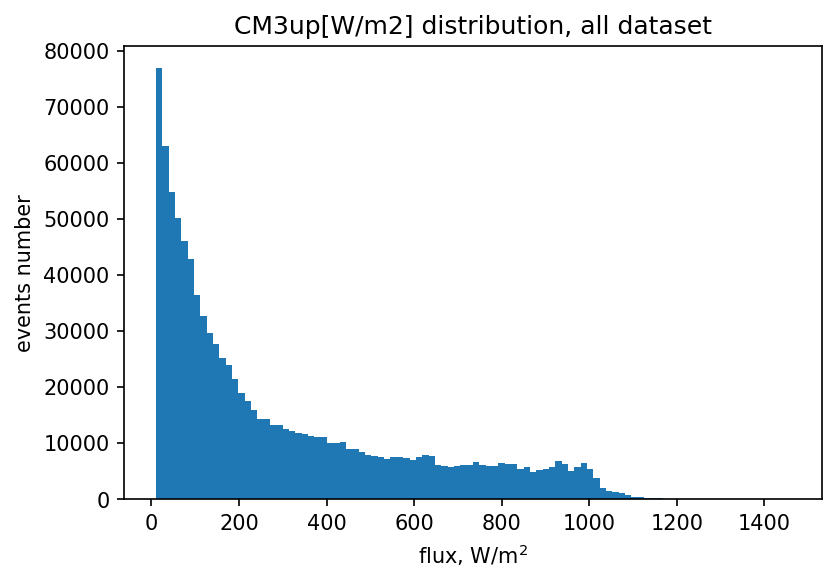

In [5]:
plt.figure(dpi=150, figsize=(6, 4))
plt.hist(metadata_loader.all_df['CM3up[W/m2]'], bins=100)
plt.title('CM3up[W/m2] distribution, all dataset')
plt.ylabel('events number')
plt.xlabel(r'flux, W/m$^2$')

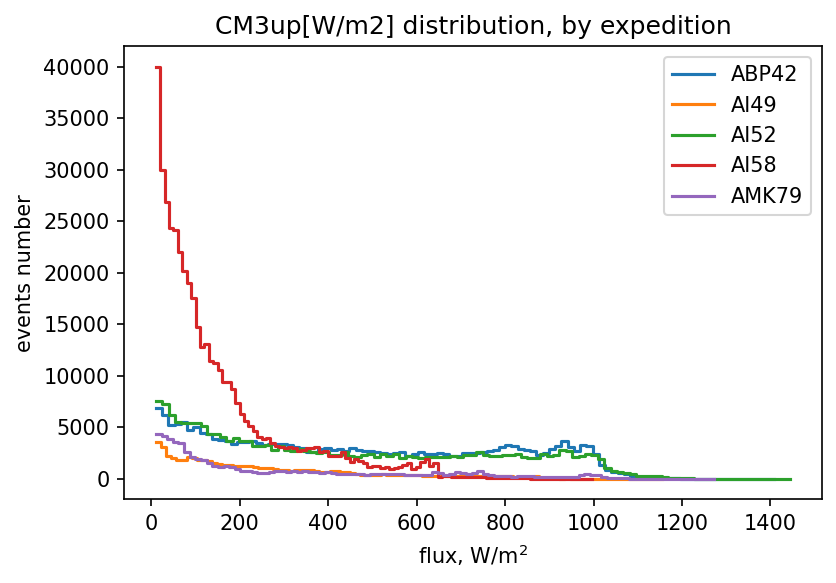

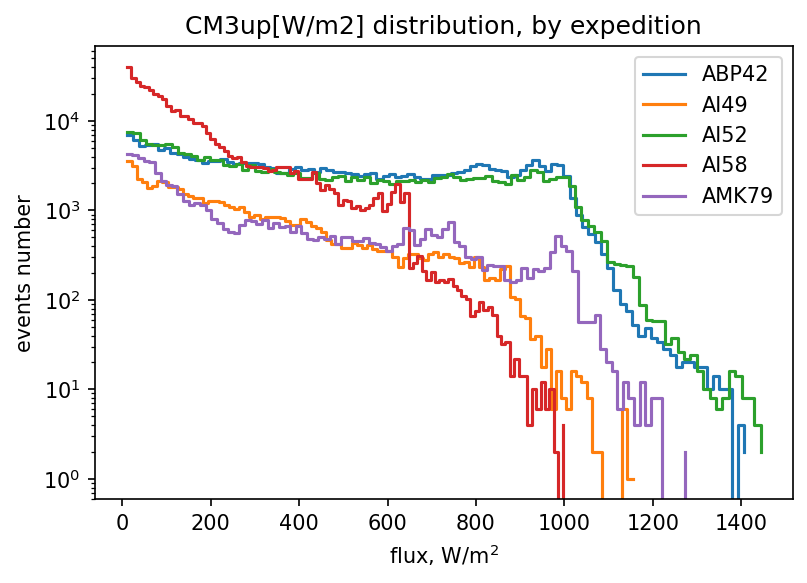

In [6]:
plt.figure(dpi=150, figsize=(6, 4))

for expedition_name, subset in metadata_loader.all_df.groupby('expedition_name'):
    hist_i, bin_edges = np.histogram(subset['CM3up[W/m2]'], bins=100,)
    # plt.hist(subset['CM3up[W/m2]'], bins=100, label=expedition_name, alpha=0.5)
    # bin_center = (bin_edges[: -1] + bin_edges[1:]) / 2
    plt.step(bin_edges[: -1], hist_i, where='post', label=expedition_name,)
    
plt.title('CM3up[W/m2] distribution, by expedition')
plt.ylabel('events number')
plt.xlabel(r'flux, W/m$^2$')
plt.legend()
plt.show(close=False)
plt.yscale('log')
plt.show()

Text(0.5, 0, 'sun elevation, degree')

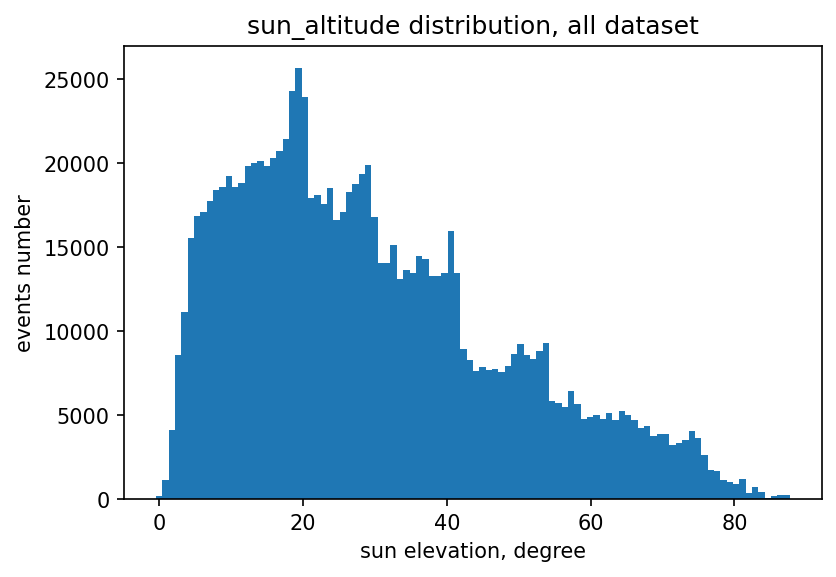

In [7]:
plt.figure(dpi=150, figsize=(6, 4))
plt.hist(metadata_loader.all_df['sun_altitude'], bins=100)
plt.title('sun_altitude distribution, all dataset')
plt.ylabel('events number')
plt.xlabel(r'sun elevation, degree')

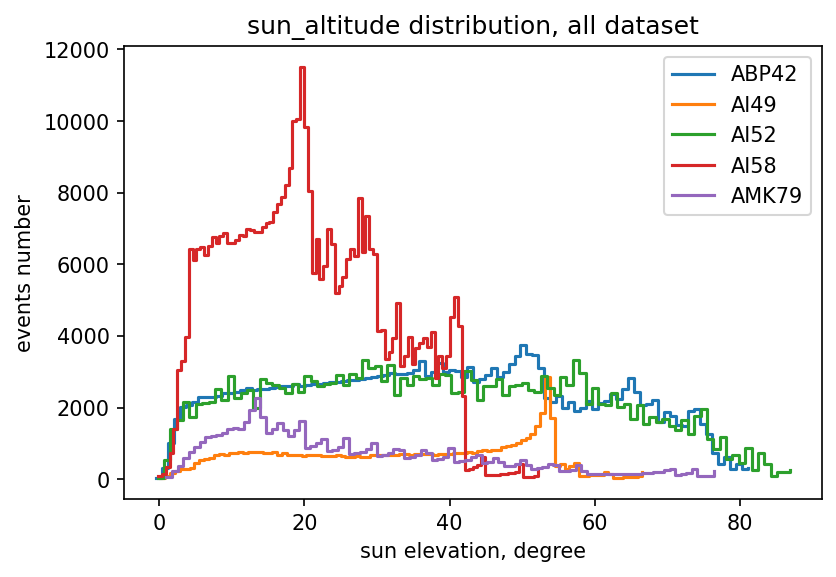

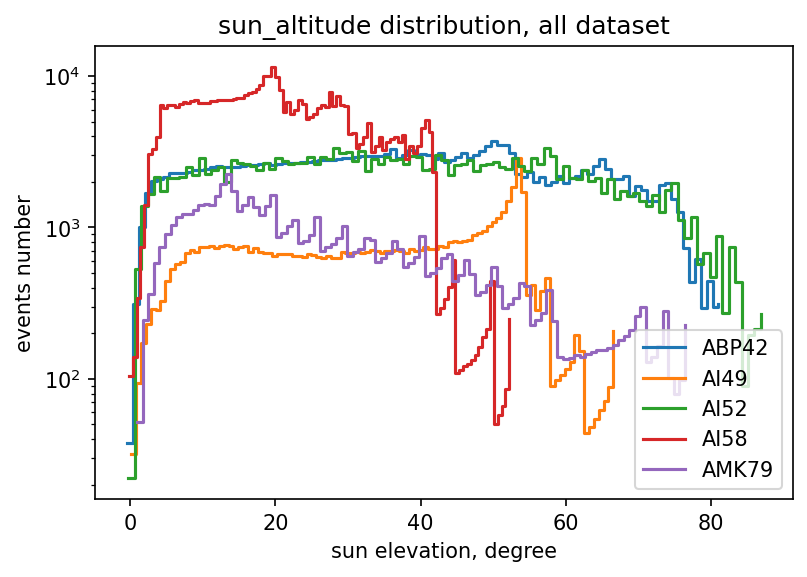

In [8]:
plt.figure(dpi=150, figsize=(6, 4))

for expedition_name, subset in metadata_loader.all_df.groupby('expedition_name'):
    hist_i, bin_edges = np.histogram(subset['sun_altitude'], bins=100,)
    plt.step(bin_edges[:-1], hist_i, where='post', label=expedition_name,)
    
plt.title('sun_altitude distribution, all dataset')
plt.ylabel('events number')
plt.xlabel(r'sun elevation, degree')
plt.legend()
plt.show(close=False)
plt.yscale('log')
plt.show()

100%|█████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


Text(0.5, 0, 'pixel value')

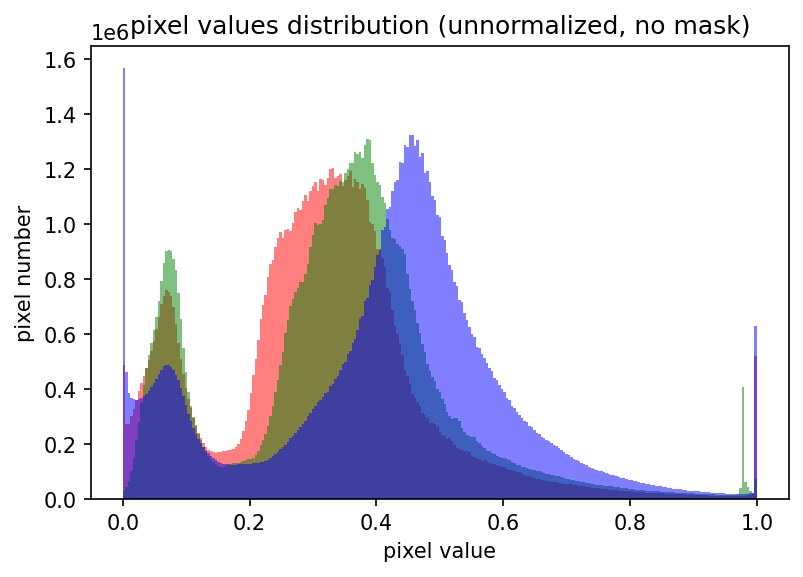

In [9]:
bins = 255
hist_collector = np.zeros((bins, 3))

n = 10
for batch_idx, batch in tqdm(enumerate(dataset), total=n):
    batch.to_tensor()
    for i in range(3):
        hist_i, bin_edges = np.histogram(
            batch.images[:, i, :, :],
            bins=bins,
            range=(0, 1),
            density=False)
        hist_collector[:, i] += hist_i
    
    if batch_idx == n:
        break
    
plt.figure(dpi=150, figsize=(6, 4))
for i, color in enumerate(('red', 'green', 'blue')):
    plt.bar(x=bin_edges[:-1],
            height=hist_collector[:, i],
            width=np.diff(bin_edges),
            align='edge',
           color=color,
           alpha = 0.5)
plt.title('pixel values distribution (unnormalized, no mask)')
plt.ylabel('pixel number')
plt.xlabel(r'pixel value')

100%|█████████████████████████████████████████| 10/10 [00:24<00:00,  2.43s/it]


Text(0.5, 0, 'pixel value')

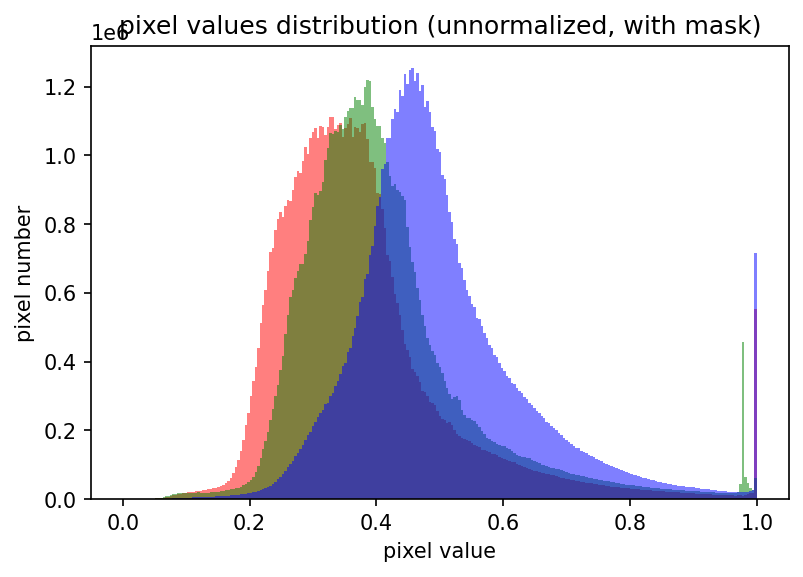

In [10]:
bins = 255
hist_collector = np.zeros((bins, 3))

n = 10
for batch_idx, batch in tqdm(enumerate(dataset), total=n):
    batch.to_tensor()
    batch.images = np.ma.masked_array(batch.images, np.where(batch.masks == 1, 0, 1))
    for i in range(3):
        hist_i, bin_edges = np.histogram(
            batch.images[:, i, :, :].compressed(),
            bins=bins,
            range=(0, 1),
            density=False)
        hist_collector[:, i] += hist_i
    
    if batch_idx == n:
        break

plt.figure(dpi=150, figsize=(6, 4))
for i, color in enumerate(('red', 'green', 'blue')):
    plt.bar(x=bin_edges[:-1],
            height=hist_collector[:, i],
            width=np.diff(bin_edges),
            align='edge',
           color=color,
           alpha = 0.5)
plt.title('pixel values distribution (unnormalized, with mask)')
plt.ylabel('pixel number')
plt.xlabel(r'pixel value')

In [11]:
batch_factory = BatchFactory(dataset=dataset,
                             cuda_device=cuda_device,
                             do_augment=False,
                             cpu_queue_length=4,
                             cuda_queue_length=4,
                             preprocess_worker_number=15,
                             cuda_feeder_number=1,
                             to_variable=True, )

In [12]:
bins = 256
hist_collector = np.zeros((bins, 3))
bin_edges = np.zeros((bins + 1, 3))

n = 10
for batch_idx in trange(n):
    batch = batch_factory.cuda_queue.get()
    for i in range(3):
        hist_i, bin_edges_i = np.histogram(
            batch.images[:, i, :, :].cpu(),
            bins=bins,
            density=False)
        hist_collector[:, i] += hist_i
        bin_edges[:, i] = bin_edges_i

100%|█████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


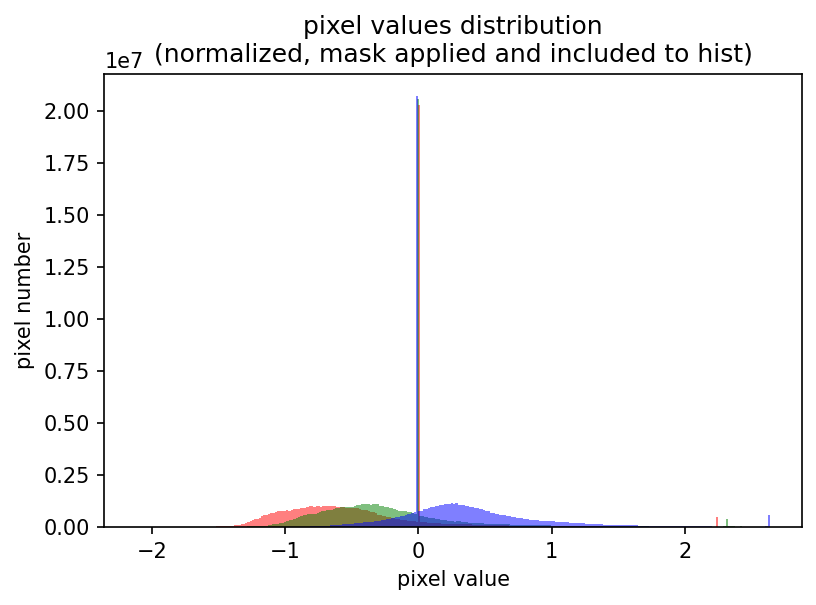

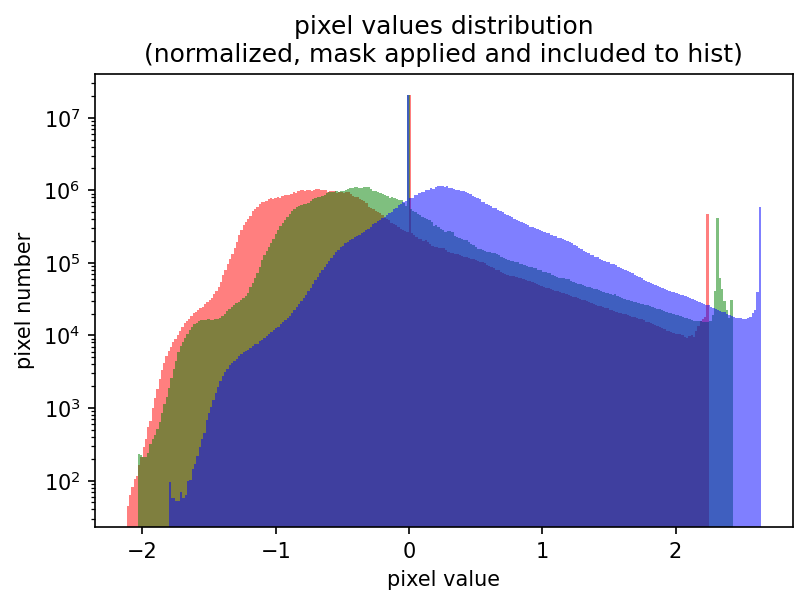

In [13]:
plt.figure(dpi=150, figsize=(6, 4))
for i, color in enumerate(('red', 'green', 'blue')):
    plt.bar(
        x=bin_edges[:-1, i],
        height=hist_collector[:, i],
        width=np.diff(bin_edges[:, i]),
        align='edge',
        color=color,
        alpha=0.5)
plt.title('pixel values distribution\n(normalized, mask applied and included to hist)')
plt.ylabel('pixel number')
plt.xlabel(r'pixel value')
plt.show(close=False)
plt.yscale('log')

In [14]:
bins = 256
hist_collector = np.zeros((bins, 3))
bin_edges = np.zeros((bins + 1, 3))

n = 10
for batch_idx in trange(n):
    batch = batch_factory.cuda_queue.get()
    batch.images = np.ma.masked_array(
        batch.images.cpu(), np.where(batch.masks.cpu() == 1, 0, 1))

    for i in range(3):
        hist_i, bin_edges_i = np.histogram(
            batch.images[:, i, :, :].compressed(),
            bins=bins,
            density=False)
        hist_collector[:, i] += hist_i
        bin_edges[:, i] = bin_edges_i

100%|█████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


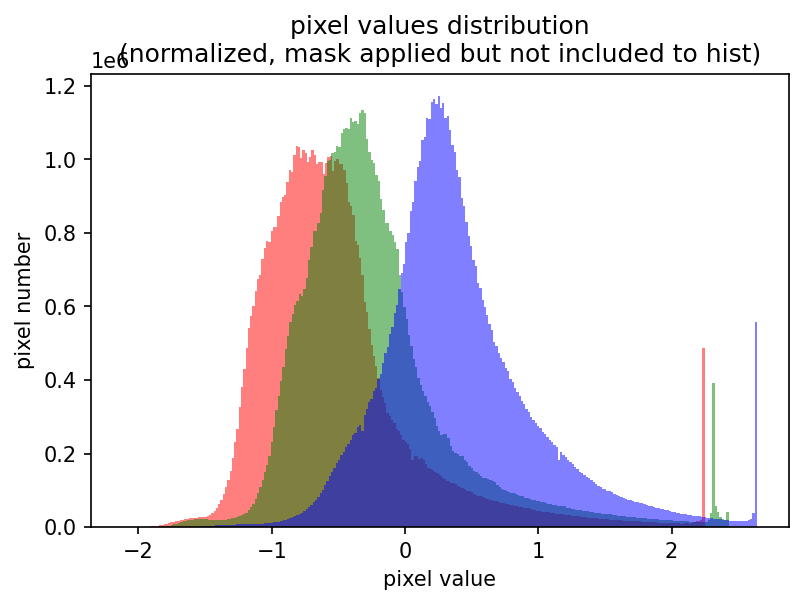

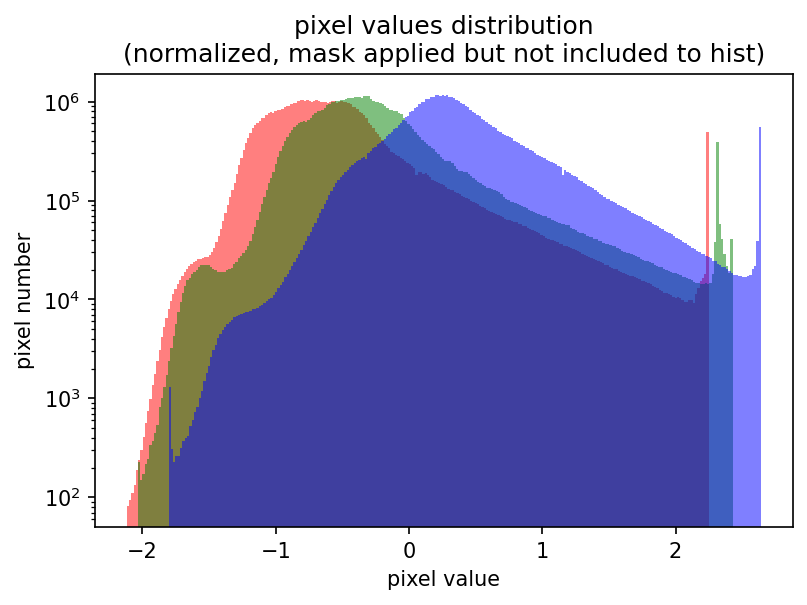

In [15]:
plt.figure(dpi=150, figsize=(6, 4))
for i, color in enumerate(('red', 'green', 'blue')):
    plt.bar(
        x=bin_edges[:-1, i],
        height=hist_collector[:, i],
        width=np.diff(bin_edges[:, i]),
        align='edge',
        color=color,
        alpha=0.5)
plt.title('pixel values distribution\n(normalized, mask applied but not included to hist)')
plt.ylabel('pixel number')
plt.xlabel(r'pixel value')
plt.show(close=False)
plt.yscale('log')

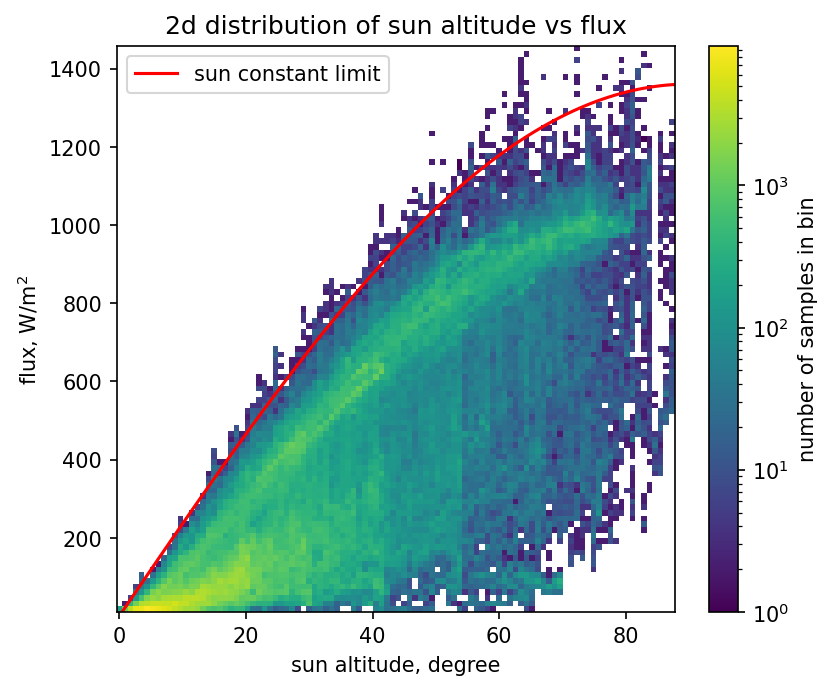

In [17]:
plt.figure(dpi=150, figsize=(6, 5))
plt.hist2d(
    metadata_loader.all_df.sun_altitude,
    metadata_loader.all_df['CM3up[W/m2]'],
    bins=100,
    cmin=0.1,
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(label='number of samples in bin')

sun_flux_x = np.linspace(0, 90, 100)
sun_flux_y = 1360.8 * np.sin(sun_flux_x * np.pi / 180)
plt.plot(sun_flux_x, sun_flux_y, color='red', label='sun constant limit')

plt.title('2d distribution of sun altitude vs flux')
plt.ylabel(r'flux, W/m$^2$')
plt.xlabel('sun altitude, degree')
plt.legend()

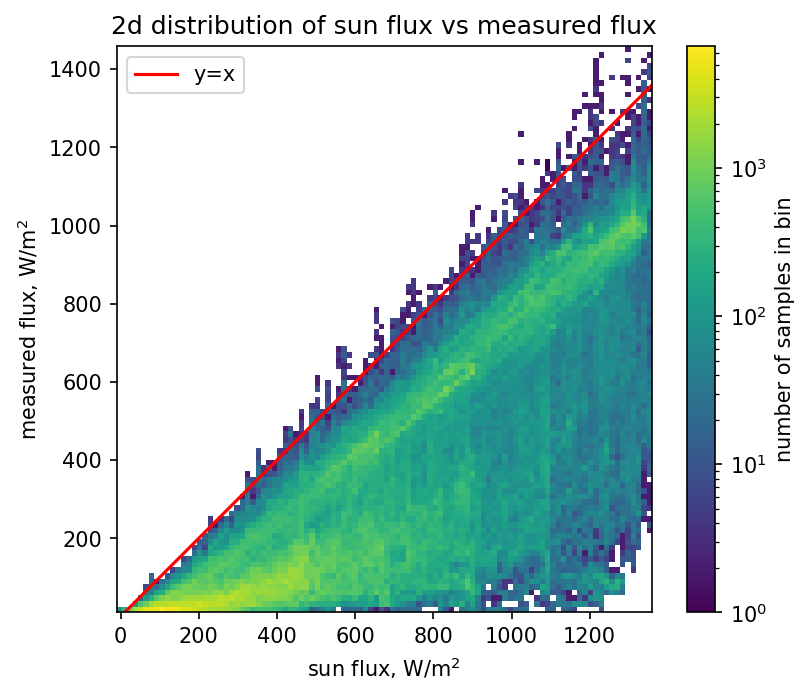

In [18]:
sun_flux = 1360.8 * np.sin(metadata_loader.all_df.sun_altitude * np.pi / 180)

plt.figure(dpi=150, figsize=(6, 5))
plt.hist2d(
    sun_flux,
    metadata_loader.all_df['CM3up[W/m2]'],
    bins=100,
    cmin=0.1,
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(label='number of samples in bin')

plt.plot((0, sun_flux.max()), (0, sun_flux.max()), color='red', label='y=x')

plt.gca().set_aspect('equal')
plt.title('2d distribution of sun flux vs measured flux')
plt.ylabel(r'measured flux, W/m$^2$')
plt.xlabel(r'sun flux, W/m$^2$')
plt.legend(loc='upper left')

# Estimate mean and std for image canals

In [19]:
batch_factory.stop()

cuda_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed
cpu_feeder_killed


In [22]:
mean_collector = np.zeros((3))
n = 10

for batch_idx, batch in tqdm(enumerate(dataset), total=n):
    batch.to_tensor()
    batch.images = np.ma.masked_array(batch.images, np.where(batch.masks == 1, 0, 1))
    for i in range(3):
        mean_collector[i] += batch.images[:, i, :, :].compressed().sum()
    
    if batch_idx == n:
        break
mean_collector = mean_collector / n / batch_size / np.product(output_size)
mean_collector

100%|█████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


array([0.31159657, 0.34272483, 0.4170931 ])

In [23]:
std_collector = np.zeros((3))
n = 10

for batch_idx, batch in tqdm(enumerate(dataset), total=n):
    batch.to_tensor()
    batch.images = np.ma.masked_array(batch.images, np.where(batch.masks == 1, 0, 1))
    for i in range(3):
        std_collector[i] += \
            np.square(batch.images[:, i, :, :].compressed() - mean_collector[i]).sum()
    
    if batch_idx == n:
        break
std_collector = std_collector / n / batch_size / np.product(output_size)
std_collector = np.sqrt(std_collector)
std_collector

100%|█████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


array([0.14429515, 0.14613416, 0.15256534])